Числові атрибути: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'age_minmax', 'age_zscore']


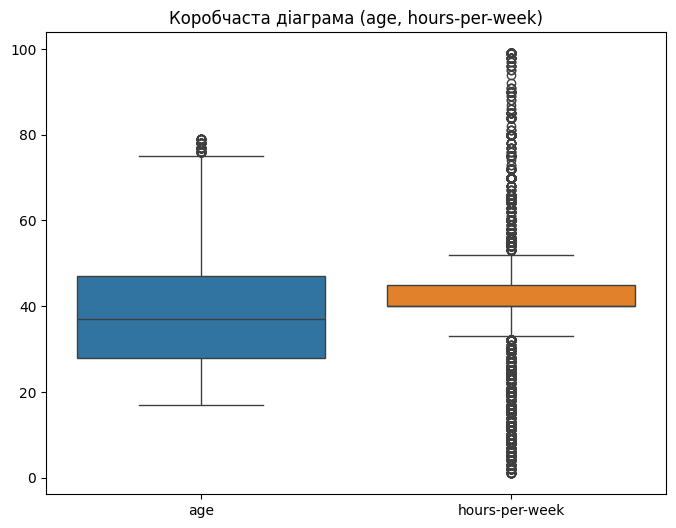

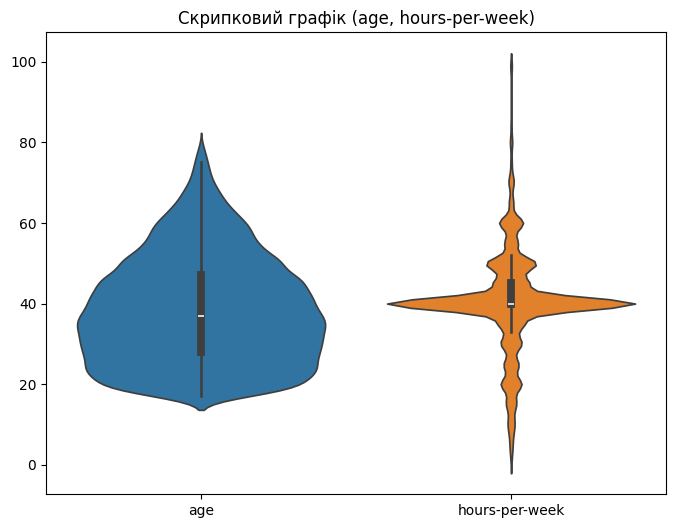

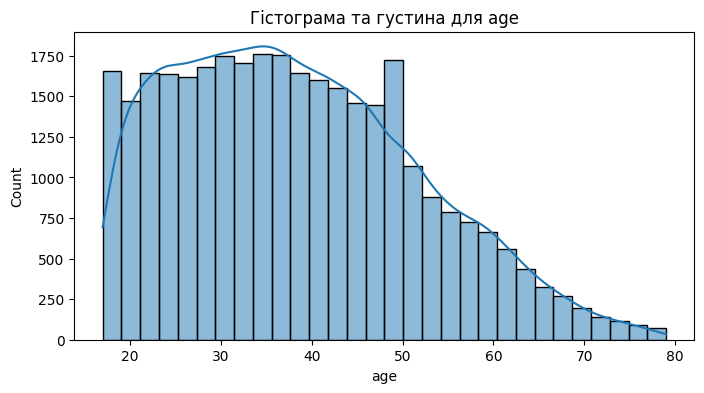

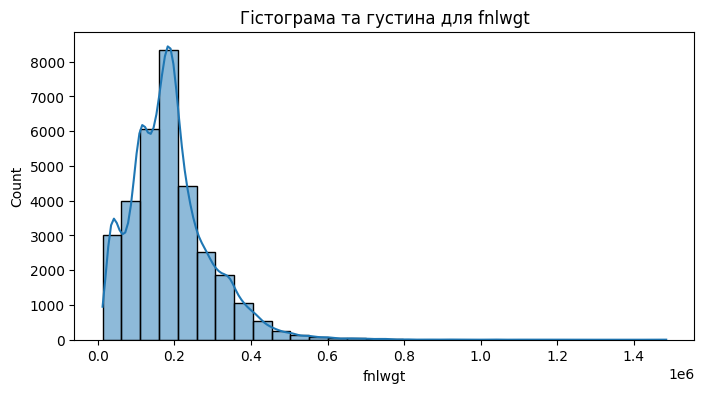

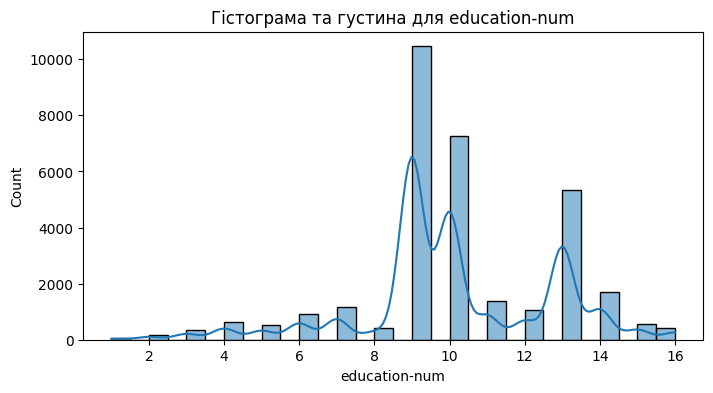

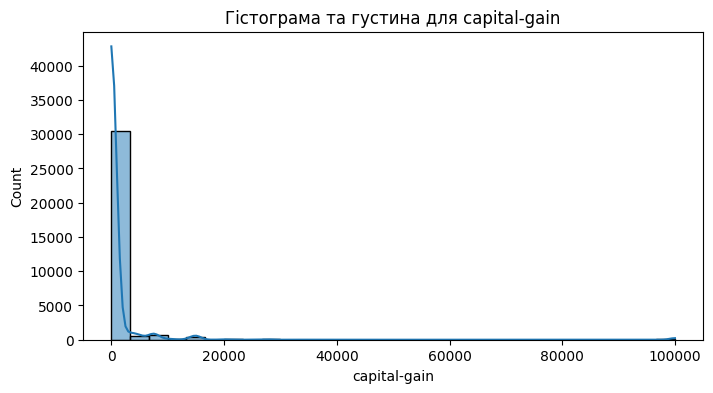

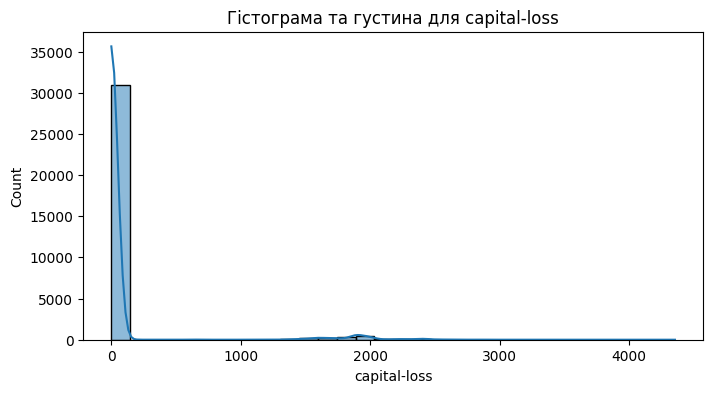

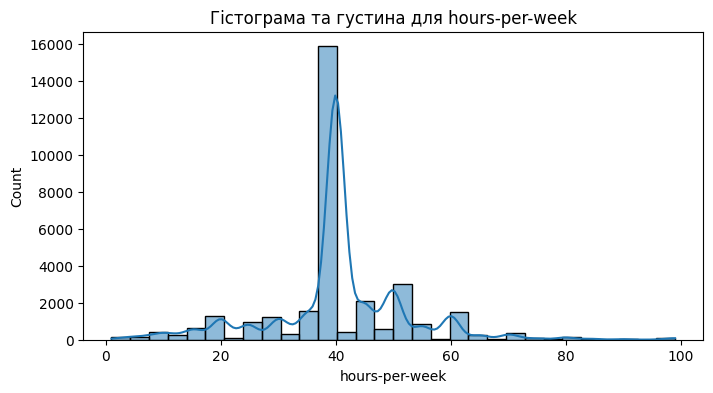

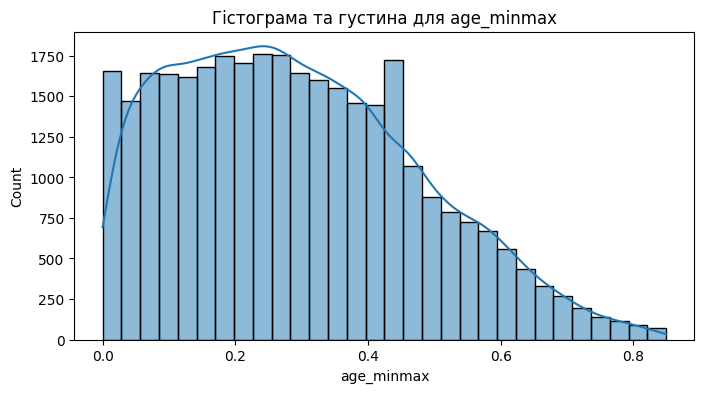

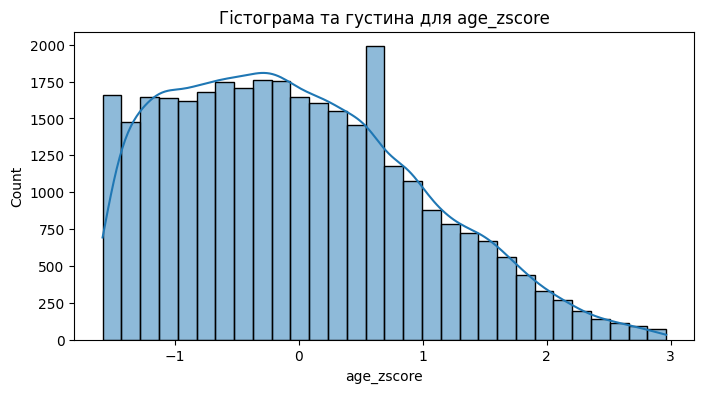

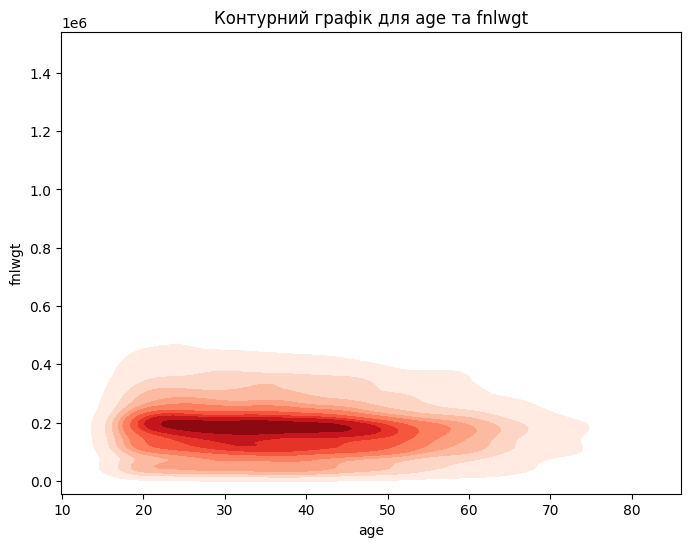

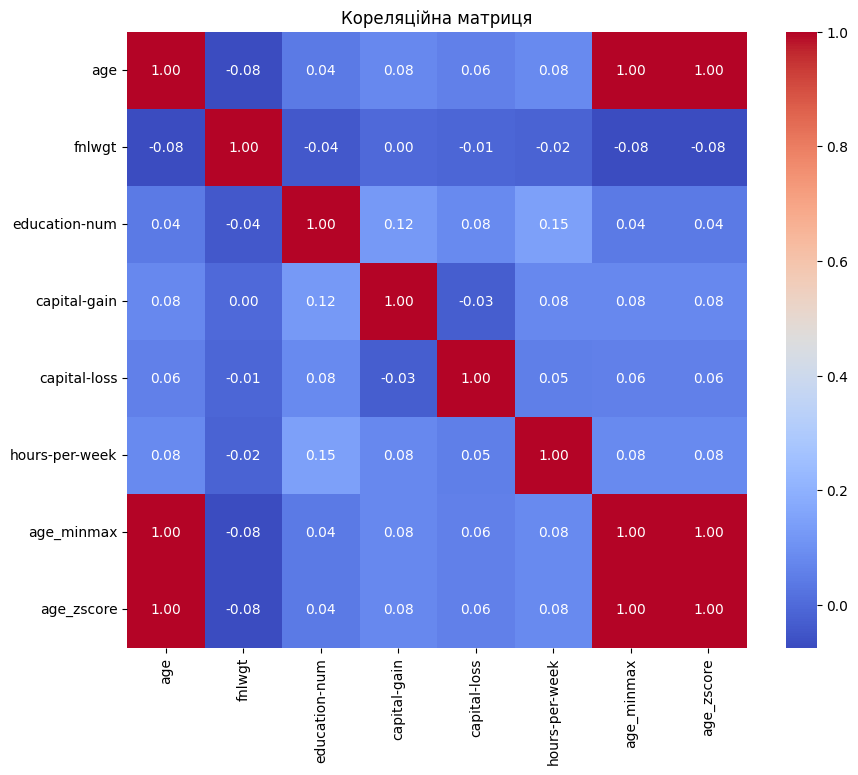


Кореляційна матриця:
                      age    fnlwgt  education-num  capital-gain  capital-loss  \
age             1.000000 -0.075121       0.041005      0.079492      0.057136   
fnlwgt         -0.075121  1.000000      -0.043339      0.000459     -0.009475   
education-num   0.041005 -0.043339       1.000000      0.122713      0.080487   
capital-gain    0.079492  0.000459       0.122713      1.000000     -0.031598   
capital-loss    0.057136 -0.009475       0.080487     -0.031598      1.000000   
hours-per-week  0.082650 -0.019604       0.147309      0.078142      0.054863   
age_minmax      1.000000 -0.075121       0.041005      0.079492      0.057136   
age_zscore      1.000000 -0.075121       0.041005      0.079492      0.057136   

                hours-per-week  age_minmax  age_zscore  
age                   0.082650    1.000000    1.000000  
fnlwgt               -0.019604   -0.075121   -0.075121  
education-num         0.147309    0.041005    0.041005  
capital-gain       

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA

# ----------------------
# 0. Зчитування даних
# ----------------------
df = pd.read_csv(r"C:\Users\anon\Downloads\adult\adult_clean_normalized.csv")

# Визначимо числові атрибути
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Числові атрибути:", numeric_cols)

# ----------------------
# 1. Коробчаста діаграма (Boxplot) для 2 атрибутів
# ----------------------
cols = ['age', 'hours-per-week']

plt.figure(figsize=(8,6))
sns.boxplot(data=df[cols])
plt.title("Коробчаста діаграма (age, hours-per-week)")
plt.show()

# ----------------------
# 2. Скрипковий графік (Violin plot) для 2 атрибутів
# ----------------------
plt.figure(figsize=(8,6))
sns.violinplot(data=df[cols])
plt.title("Скрипковий графік (age, hours-per-week)")
plt.show()

# ----------------------
# 3. Гістограма + густина для всіх числових
# ----------------------
for col in numeric_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Гістограма та густина для {col}")
    plt.show()

# ----------------------
# 4. Контурний графік для перших двох числових атрибутів
# ----------------------
plt.figure(figsize=(8,6))
sns.kdeplot(x=df[numeric_cols[0]], y=df[numeric_cols[1]], fill=True, cmap="Reds")
plt.title(f"Контурний графік для {numeric_cols[0]} та {numeric_cols[1]}")
plt.show()

# ----------------------
# 5. Кореляційна матриця
# ----------------------
cor = df[numeric_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(cor, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Кореляційна матриця")
plt.show()

print("\nКореляційна матриця:\n", cor)

# ----------------------
# 6. PCA для всіх числових
# ----------------------
pca = PCA(n_components=len(numeric_cols))
pca.fit(df[numeric_cols])

explained_variance = pca.explained_variance_ratio_
components = pd.DataFrame(pca.components_, columns=numeric_cols)
print("\nДисперсія, яку пояснює кожна компонента:")
print(explained_variance)
print("\nКомпоненти та залежні атрибути:\n", components)

# ----------------------
# 7. Мода та стандартна похибка
# ----------------------
print("\nМода та стандартна похибка:")
for col in numeric_cols:
    mode_val = df[col].mode()[0]
    std_err = stats.sem(df[col])
    print(f"{col}: Мода = {mode_val}, Стандартна похибка = {std_err:.3f}")

# ----------------------
# 8. Автоматичне визначення типу розподілу
# ----------------------
print("\nОцінка типу розподілу:")

def detect_distribution(series):
    # Нормальний розподіл
    k2, p_norm = stats.normaltest(series)
    # Експоненційний (Показниковий)
    ks_exp = stats.kstest(series, 'expon', args=(series.min(), series.mean()))
    # Рівномірний
    ks_uni = stats.kstest(series, 'uniform', args=(series.min(), series.max() - series.min()))
    
    best_fit = min([('Гаусовський', p_norm), 
                    ('Показниковий', ks_exp.pvalue),
                    ('Рівномірний', ks_uni.pvalue)], 
                   key=lambda x: 1 - x[1])
    return best_fit[0]

for col in numeric_cols:
    dist_type = detect_distribution(df[col].dropna())
    print(f"{col}: розподіл схожий на {dist_type}")

# ----------------------
# 9. Бутстрап (1000 вибірок)
# ----------------------
np.random.seed(42)
bootstrap_samples = 1000

print("\nДовірчі інтервали (бутстрап 95%):")
for col in numeric_cols:
    boot_means = [df[col].sample(frac=1, replace=True).mean() for _ in range(bootstrap_samples)]
    ci_lower = np.percentile(boot_means, 2.5)
    ci_upper = np.percentile(boot_means, 97.5)
    print(f"{col}: [{ci_lower:.3f}, {ci_upper:.3f}]")
